# Custom State Tomography Demo

The core aim of QSTToolkit is to provide a modular, 'drag-and-drop' sandbox environment for combining elements of existing quantum state tomography methods, into tailor-made solutions for a given experimental use case. This notebook demonstrates the construction of a custom QST method: a hybrid of the GAN and MLE approaches, using the `CustomQuantumStateTomography` class.

## Install libraries to runtime

If running in Google Colab, run the following setup cell once each time you open your project in order to install non-default package dependencies to the runtime. DO NOT RUN if you have already created a kernel with `qsttoolkit` as per the setup instructions in `README.md`.

In [ ]:
!pip install qsttoolkit

## Imports

All of QSTToolkit's features can be accessed by importing `qsttoolkit` and calling them directly. Most features sit within two main subpackages: `.data` and `.tomography`. In this example notebook, functions are called from their subpackage where relevant to show which features sit in each subpackage, and which lie in modules outside either:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import tensorflow as tf
import qsttoolkit as qst

## Data Preparation

We start by defining the Hilbert space dimensionality of our system as `dim`, and the phase space grid for our measurement data - the Husimi Q representation of a state in phase space. This grid is defined to be `data_dim` x `data_dim`:

In [3]:
dim = 32
data_dim = 32                 # Dimensions of the phase space grid that will serve as the image size for our data
xgrid = np.linspace(-5, 5, data_dim)
pgrid = np.linspace(-5, 5, data_dim)

We first create test state density matrices of seven different varieties using the [QuTiP](https://qutip.org/docs/4.0.2/index.html) framework. The first three states can be produced directly using QuTiP functions, the other four are specific superpositions of Fock and coherent states and are produced using custom functions in `qsttoolkit.data`:

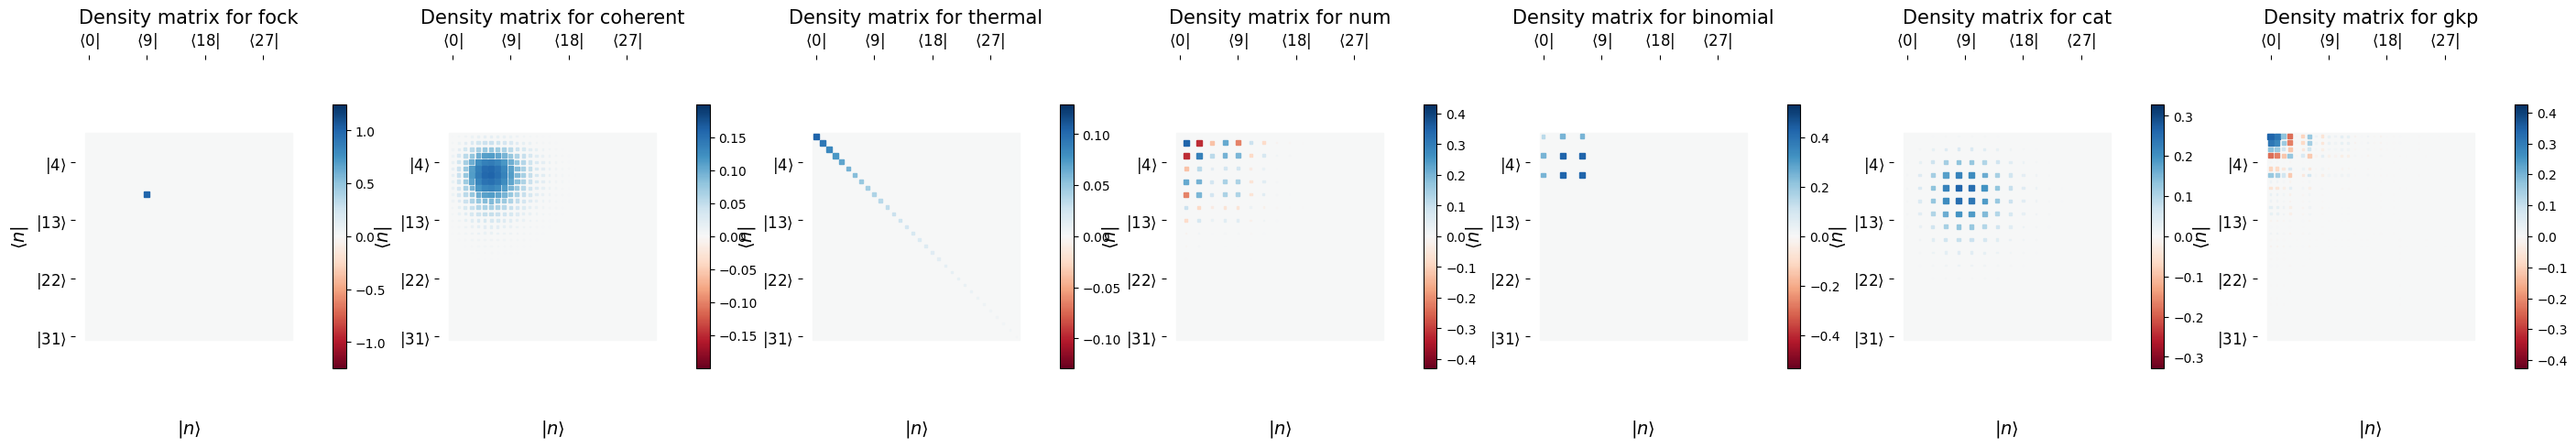

In [4]:
fock_test = qt.fock_dm(dim, 9)
coherent_test = qt.coherent_dm(dim, 2.5)
thermal_test = qt.thermal_dm(dim, 9)
num_test = qst.data.num_dm('M2', dim)
binomial_test = qst.data.binomial_dm(dim, 2, 2, 1)
cat_test = qst.data.cat_dm(dim, 3)
gkp_test = qst.data.gkp_dm(dim, [-5, 5], [-5, 5], 0.5, 4.5)

fig, ax = plt.subplots(1, 7, figsize=(35, 5))
qst.plot_hinton(fock_test, ax=ax[0], label='fock')
qst.plot_hinton(coherent_test, ax=ax[1], label='coherent')
qst.plot_hinton(thermal_test, ax=ax[2], label='thermal')
qst.plot_hinton(num_test, ax=ax[3], label='num')
qst.plot_hinton(binomial_test, ax=ax[4], label='binomial')
qst.plot_hinton(cat_test, ax=ax[5], label='cat')
qst.plot_hinton(gkp_test, ax=ax[6], label='gkp')
plt.show()

We create the measurement operators for heterodyne detection of quantum states using `qsttoolkit.data.measurement_operators()`:

In [5]:
measurement_operators = qst.data.measurement_operators(dim, 'heterodyne', xgrid=xgrid, pgrid=pgrid)

We choose our test state and apply mixed state noise, and then create the POVM expectation probabilities for our given measurement regime:

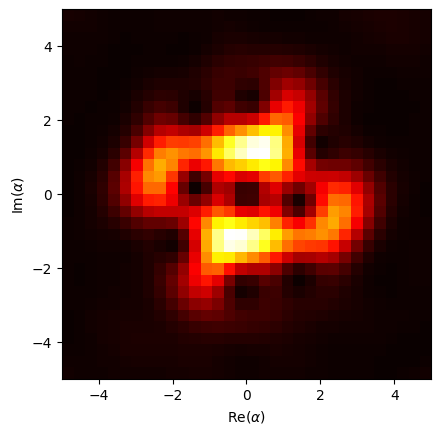

In [ ]:
test_state = qst.data.mixed_state_noise(num_test, 0.2)
expectation_values = qst.expectation(test_state, measurement_operators, numpy=True)
expectation_values /= np.sum(expectation_values)                                # Normalize to create valid probabilities

plt.imshow(expectation_values.reshape(data_dim, data_dim), extent=[-5, 5, -5, 5],cmap='hot')
plt.xlabel("Re($\\alpha$)")
plt.ylabel("Im($\\alpha$)")
plt.show()

We then sample our finite measurement shots of the state:

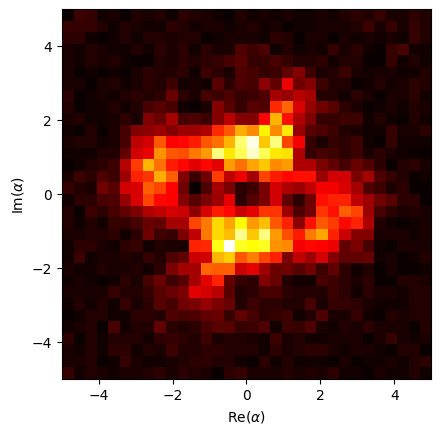

In [7]:
measurement_data = qst.data.measure_shots(expectation_values, num_shots=10000)

plt.imshow(measurement_data.reshape(data_dim, data_dim), extent=[-5, 5, -5, 5],cmap='hot')
plt.xlabel("Re($\\alpha$)")
plt.ylabel("Im($\\alpha$)")
plt.show()

## Modelling

To perform custom tomography, we first define a 'training step' function, taking the inputs: `(model, measurement_data, measurement_operators)` and returning: `(density_matrix, loss_value)`. For example, using the log-likelihood function from maximum likelihood estimation:

In [ ]:
def train_step_ll(model, measurement_data, measurement_operators):
    parametrized_generated_dm = model(measurement_data)
    generated_dm = qst.tomography.reconstruct_density_matrix(parametrized_generated_dm)
    loss = qst.tomography.log_likelihood(generated_dm, measurement_data, measurement_operators)
    return generated_dm, loss

Define our model, in this case the generator from QSTToolkit's GAN model:

In [9]:
model = qst.tomography.build_generator([data_dim**2])

Build our custom reconstructor object:

In [10]:
custom_reconstructor = qst.tomography.CustomQuantumStateTomography(model, train_step_ll)

Define an optimizer - default optimizers are provided for other models, but must be specified for a custom model.

In [11]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002)

Perform the reconstruction, using the same `.reconstruct` method as other tomography models in QSTToolkit:

In [12]:
import logging
tf.get_logger().setLevel(logging.ERROR)     # Suppress TensorFlow warnings that can occur in some environments

custom_reconstructor.reconstruct(measurement_data,
                                 measurement_operators,
                                 epochs=500,
                                 optimizer=optimizer,
                                 verbose_interval=50,
                                 num_progress_saves=10,        # Save the progress of the training
                                 true_dm=test_state)           # For calculating the fidelity of the reconstructed during training

Epoch 0/500, Loss: 6.907257167115393, Fidelity: 0.1741109801995968
Epoch 50/500, Loss: 6.351750204415301, Fidelity: 0.6426247918491544
Epoch 100/500, Loss: 6.276341259685694, Fidelity: 0.7349651619416614
Epoch 150/500, Loss: 6.269008087957764, Fidelity: 0.7658194496211993
Epoch 200/500, Loss: 6.265350528377755, Fidelity: 0.7912967260524428
Epoch 250/500, Loss: 6.263745550920722, Fidelity: 0.8065685051980918
Epoch 300/500, Loss: 6.262109143846504, Fidelity: 0.8129003678287358
Epoch 350/500, Loss: 6.263712867288723, Fidelity: 0.810009055969345
Epoch 400/500, Loss: 6.260404816613304, Fidelity: 0.8320525034015753
Epoch 450/500, Loss: 6.260121730241199, Fidelity: 0.8403085101604599
Reconstruction complete.


## Analysis

Analysis methods are identical to those for other models in QSTToolkit.

Model statistics over training progress:

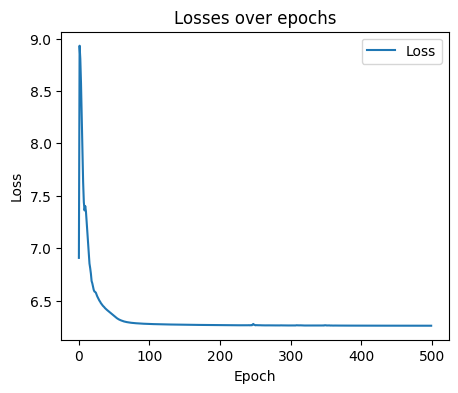

In [13]:
custom_reconstructor.plot_losses()

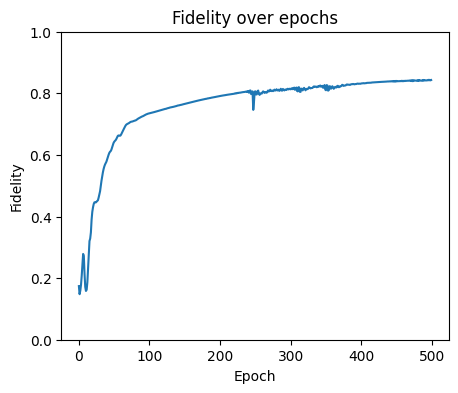

In [14]:
custom_reconstructor.plot_fidelities()

Comparison of the true and reconstructed states:

In [15]:
print(f"State fidelity: {qst.fidelity(test_state, custom_reconstructor.reconstructed_dm)}")

State fidelity: 0.8431450260376259


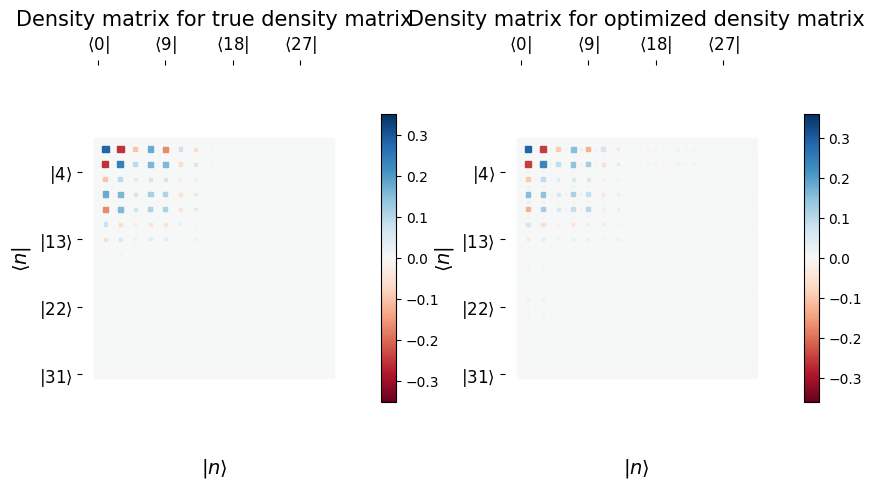

In [16]:
custom_reconstructor.plot_comparison_hintons(test_state)

Comparison of the original test data, and data sampled from the reconstructed state:

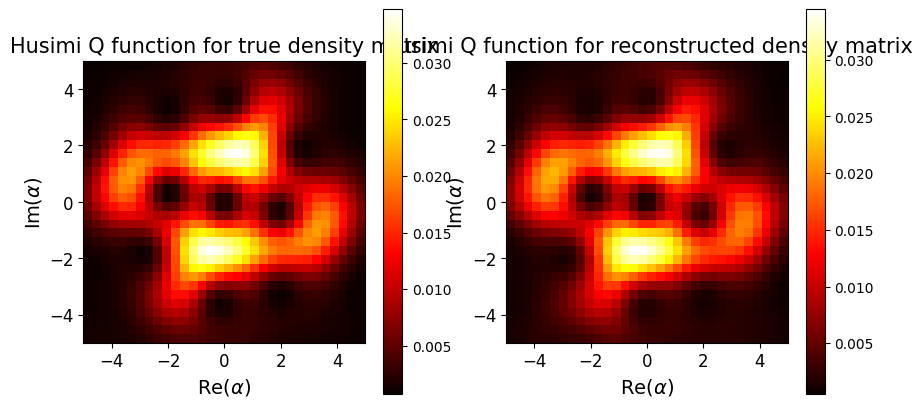

In [17]:
custom_reconstructor.plot_comparison_husimi_Qs(test_state, xgrid, pgrid)

Inspection of reconstructions from intermediate parametrizations during optimisation:

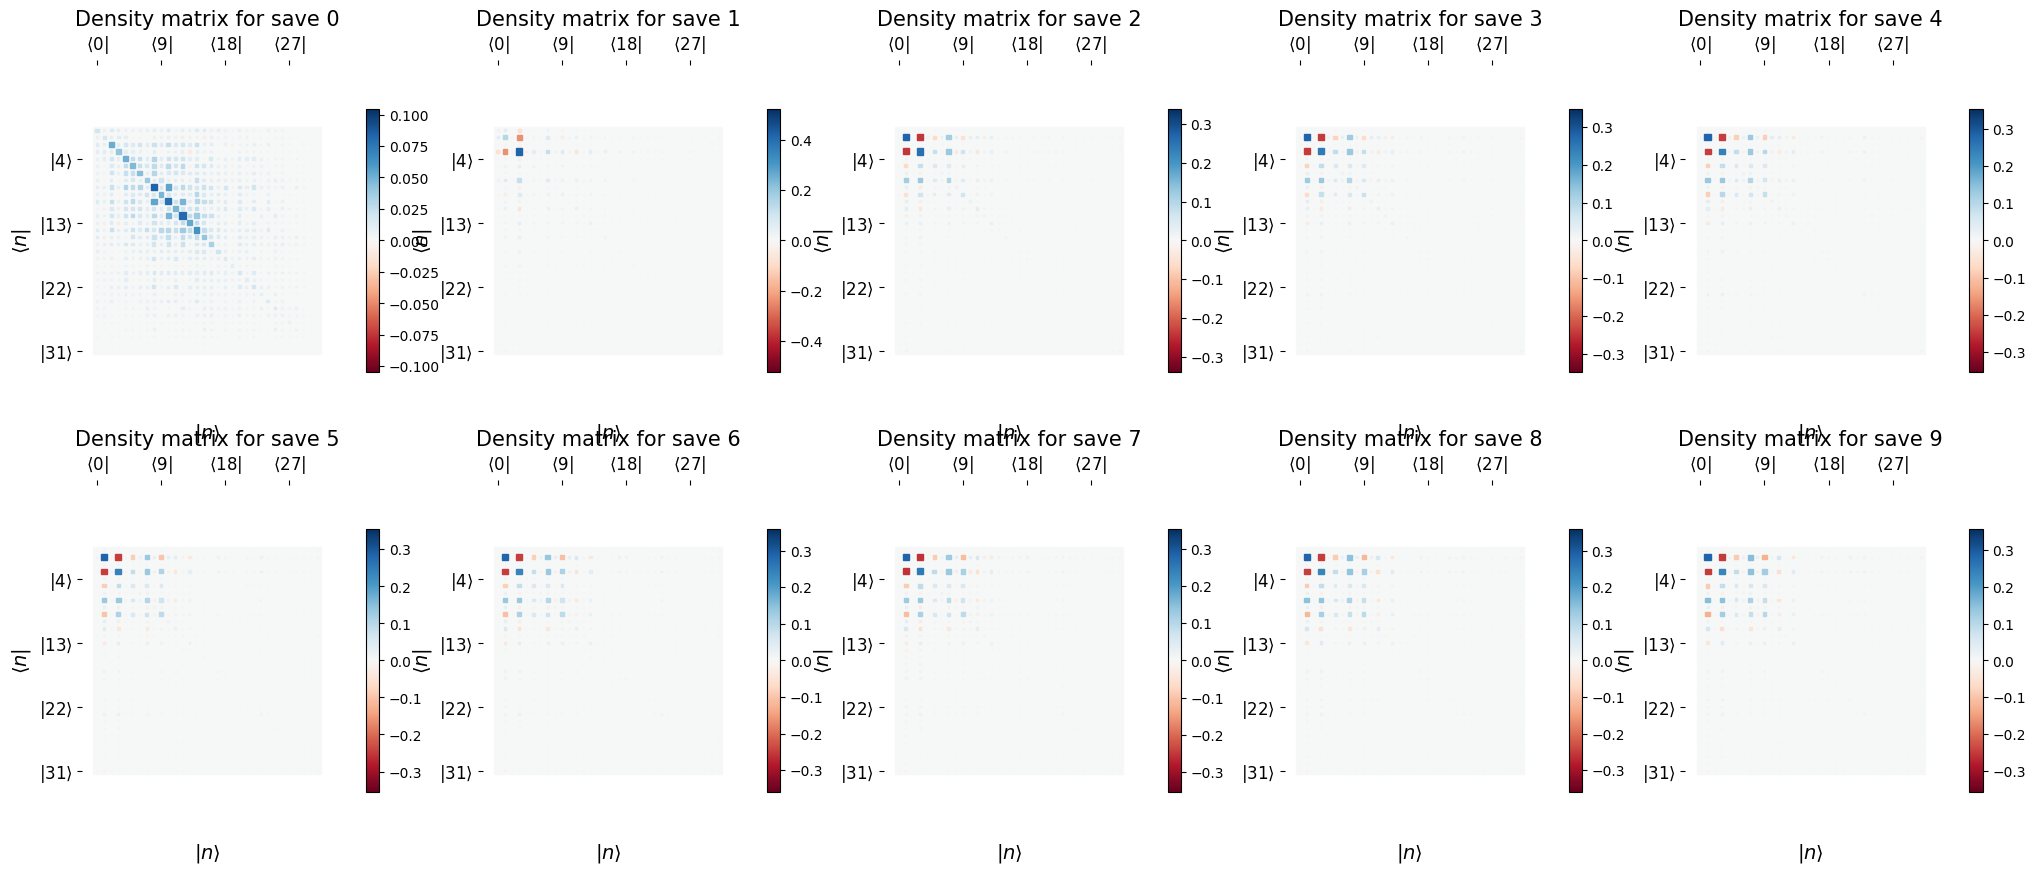

In [18]:
custom_reconstructor.plot_intermediate_hintons()

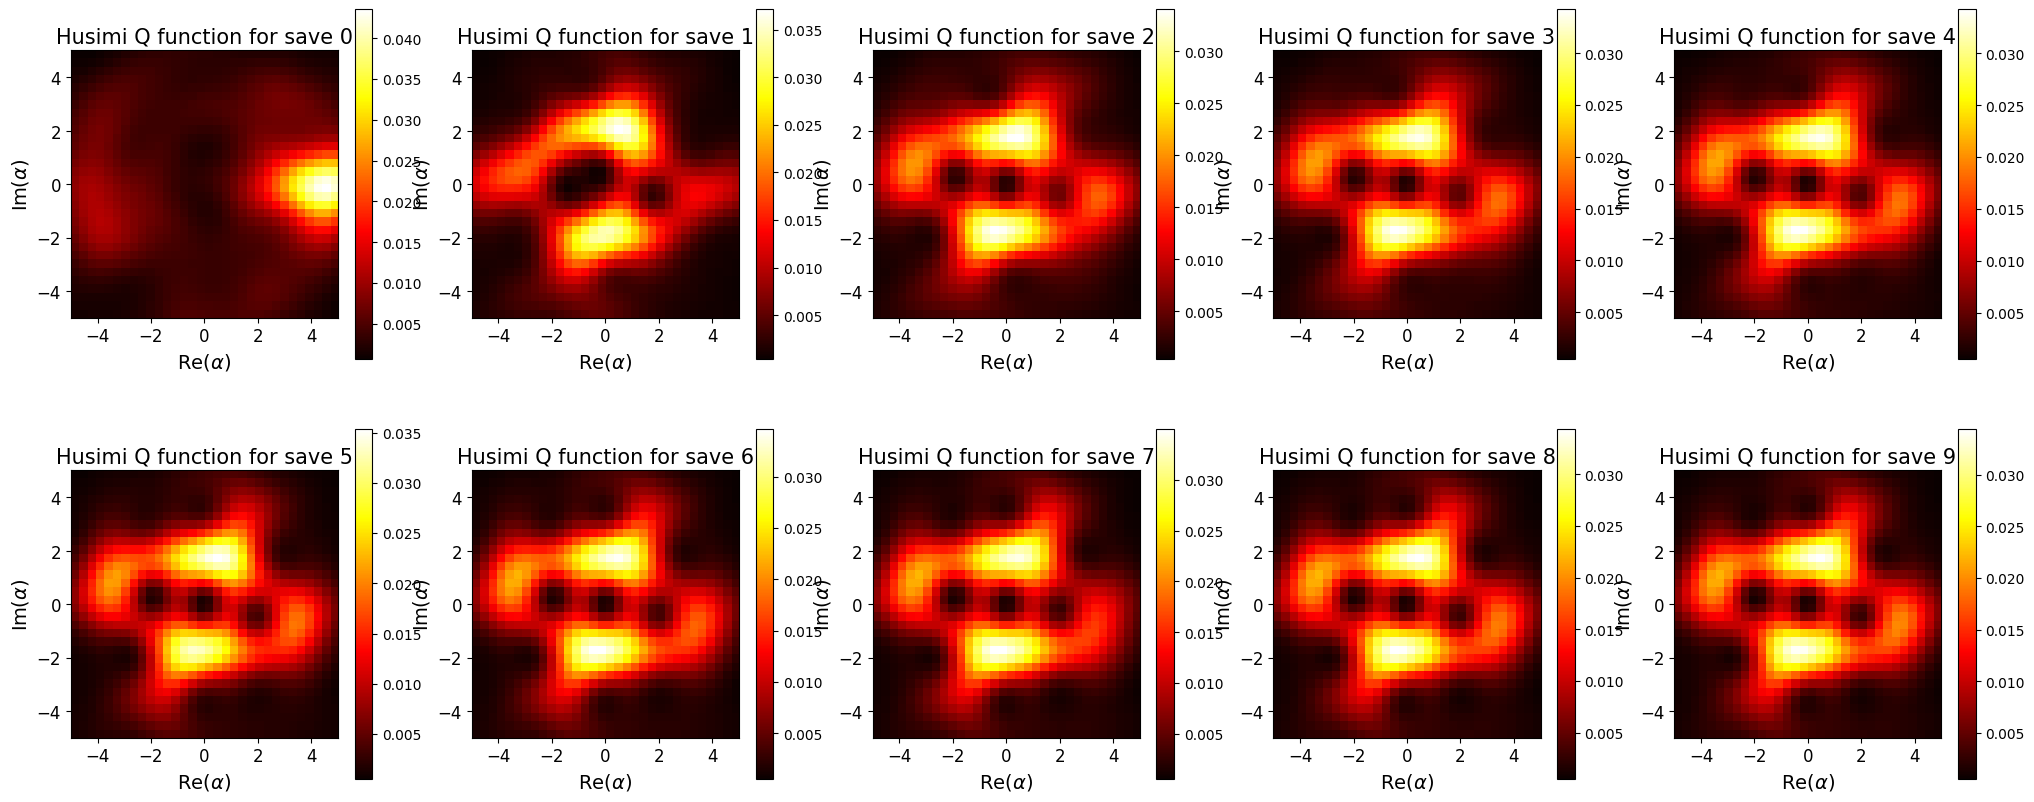

In [19]:
custom_reconstructor.plot_intermediate_husimi_Qs(xgrid, pgrid)